# Decoding the same entity by it's mention

For this experiment I will try to decode the sentences with some mentions of a named entity so that decoded sentence will contain the entity.

1. Decoded passage must contain the named entity
2. Enhancement: the passage must be non-contradictive to the original
3. Enhancement: change target from text to rdf

# Setup

In [1]:
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import gc
import os

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModel, PhrasalConstraint
from transformers.modeling_outputs import BaseModelOutput
from datasets import load_from_disk, load_dataset

In [5]:
bert_name = 'cointegrated/LaBSE-en-ru'
t5_name = 'cointegrated/rut5-base-labse-decoder' #I replace the decoder with pre trained for this task

save_model_path = './models/rut5-base-labse-mention-decoder'
if os.path.exists(save_model_path):
    t5_name = save_model_path
    print(t5_name)

In [6]:
enc_tokenizer = AutoTokenizer.from_pretrained(bert_name)
encoder = AutoModel.from_pretrained(bert_name).cuda()

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
dec_tokenizer = AutoTokenizer.from_pretrained(t5_name)
decoder = AutoModelForSeq2SeqLM.from_pretrained(t5_name).cuda()

In [8]:
def decode(embeddings, max_length=256, repetition_penalty=3.0, **kwargs):
    out = decoder.generate(
        encoder_outputs=BaseModelOutput(last_hidden_state=embeddings.unsqueeze(1)), 
        max_length=max_length, 
        repetition_penalty=repetition_penalty,
    )
    return [dec_tokenizer.decode(tokens, skip_special_tokens=True) for tokens in out]

# Data

In [9]:
import json
from pathlib import Path
from custom_types import Sample


data_dir = Path("./data")
data_path = next(data_dir.iterdir())

In [10]:
with data_path.open("r") as fin:
    data = json.load(fin)
    data = list(map(Sample.from_dict, data))

In [9]:
paraphrase("'Интер РАО' продолжает рассматривать возможность размещения активов на других международных площадках.",gram=4)

'"Интер РАО" продолжает рассматривать возможность размещать активы на других международных рынках.'

In [11]:
from custom_datasets import IterableJsonDataset

In [12]:
dataset = IterableJsonDataset(data_dir)

In [21]:
def encode(samples: list[Sample]):
    
    # Encode
    texts = [s.text for s in samples]
    encoded_input = enc_tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    decoded_input = [enc_tokenizer.batch_decode(x) for x in encoded_input["input_ids"]]
    # Align tokens with entity span
    entity_spans = locate_spans(decoded_input, samples)
        
    with torch.no_grad():
        model_output = encoder(**encoded_input.to(encoder.device))
        embeddings = []
        for text_tensor, (entity_start, entity_end) in zip(model_output.last_hidden_state, entity_spans): # (sample, tokens, dim)
            # print(text_tensor.shape)
            entity_tensor = text_tensor[entity_start:entity_end+1] # (end-start+1, dim)
            # print(entity_tensor.shape, entity_start, entity_end)
            entity_vector = torch.mean(entity_tensor, dim=0)
            # print(entity_vector.shape)
            embeddings.append(entity_vector)
            
        embeddings = torch.vstack(embeddings) # [(dim)]*n -> (n, dim)
        # print(embeddings.shape)
        embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings

In [214]:
def encode_noisy(texts, unnorm_share='random'):
    encoded_input = enc_tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        model_output = encoder(**encoded_input.to(encoder.device))
        embeddings = model_output.pooler_output
        embeddings_norm = torch.nn.functional.normalize(embeddings)
        if unnorm_share == 'random':
            unnorm_share = random.choice([0, 0, random.random(), 1])
        if unnorm_share:
            embeddings = embeddings * (1-unnorm_share) + embeddings_norm * unnorm_share
    return embeddings

# Training

In [15]:
for p in decoder.encoder.parameters():
    p.requires_grad = False
for p in decoder.decoder.parameters():
    p.requires_grad = True

In [16]:
optimizer = torch.optim.Adam([p for p in decoder.parameters() if p.requires_grad], lr=1e-5)

In [17]:
losses = []

In [18]:
batch_size = 8
# dataloader = torch.utils.data.DataLoader(dataset=dataset,collate_fn=lambda *x: x, batch_size=batch_size)
# data_iterator = iter(dataloader)

In [ ]:
report_steps = 1000  # раз в сколько шагов печатаем результат
epochs = 1  # сколько раз мы покажем данные модели

encoder.train()
decoder.train()

data_iterator = iter(dataset)
for epoch in range(epochs):
    for i in tqdm(range(1_000_000)):
        batch = []
        
        # Not all entities are good
        while len(batch) != batch_size:
            sample = next(data_iterator)
            if len(sample.ent) < 3:
                continue
            if len(enc_tokenizer(sample.text, truncation=False)["input_ids"]) > 512:
                continue
                
            batch.append(sample)
        
        try:
            embeddings = encode(batch).to(decoder.device)
        except ValueError:
            # This may happen for example if entity failed to match
            continue
        
        texts = [s.text for s in batch]
        y = dec_tokenizer(texts, return_tensors='pt', padding=True).to(decoder.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = decoder(
                encoder_outputs=BaseModelOutput(last_hidden_state=embeddings.unsqueeze(1)),
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError:
            print(i, 'error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            gc.collect()
            torch.cuda.empty_cache()
            continue
            
        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))
            decoder.save_pretrained(save_model_path)

  0%|                                                                                                                                | 0/1000000 [00:00<?, ?it/s]

step 0 loss 5.550827980041504


  0%|                                                                                                                   | 530/1000000 [01:15<40:14:41,  6.90it/s]

528 error


  0%|                                                                                                                  | 1000/1000000 [02:21<37:40:41,  7.37it/s]

step 1000 loss 3.836535280227661


  0%|                                                                                                                  | 1077/1000000 [02:34<54:30:17,  5.09it/s]

1076 error


  0%|▏                                                                                                                 | 1191/1000000 [02:50<50:51:56,  5.45it/s]

1189 error


  0%|▏                                                                                                                 | 1224/1000000 [02:55<45:57:20,  6.04it/s]

1222 error


  0%|▏                                                                                                                 | 2000/1000000 [04:44<35:44:06,  7.76it/s]

step 2000 loss 3.612840162754059


  0%|▎                                                                                                                 | 3000/1000000 [07:08<44:30:38,  6.22it/s]

step 3000 loss 3.497310962438583


  0%|▍                                                                                                                 | 3401/1000000 [08:06<49:52:49,  5.55it/s]

3400 error


  0%|▍                                                                                                                 | 4000/1000000 [09:31<38:03:37,  7.27it/s]

step 4000 loss 3.4472397108078003


  0%|▍                                                                                                                 | 4106/1000000 [09:47<51:04:59,  5.42it/s]

4105 error


  0%|▍                                                                                                                 | 4216/1000000 [10:03<48:41:22,  5.68it/s]

4214 error


  0%|▌                                                                                                                 | 5000/1000000 [11:54<38:29:36,  7.18it/s]

step 5000 loss 3.367010394334793


  1%|▌                                                                                                                 | 5440/1000000 [12:58<46:49:50,  5.90it/s]

5439 error


  1%|▋                                                                                                                 | 5552/1000000 [13:14<44:20:56,  6.23it/s]

5550 error


  1%|▋                                                                                                                 | 5681/1000000 [13:33<49:25:52,  5.59it/s]

5680 error


  1%|▋                                                                                                                 | 6000/1000000 [14:19<39:10:55,  7.05it/s]

step 6000 loss 3.3659094274044037


  1%|▊                                                                                                                 | 7000/1000000 [16:42<36:11:56,  7.62it/s]

step 7000 loss 3.3089338841438294


  1%|▊                                                                                                                 | 7353/1000000 [17:35<48:21:06,  5.70it/s]

7352 error


  1%|▉                                                                                                                 | 8000/1000000 [19:07<41:22:58,  6.66it/s]

step 8000 loss 3.236089067220688


  1%|▉                                                                                                                 | 8711/1000000 [20:49<45:51:45,  6.00it/s]

8709 error


  1%|█                                                                                                                 | 9000/1000000 [21:30<35:46:50,  7.69it/s]

step 9000 loss 3.2757527811527254


  1%|█                                                                                                                 | 9007/1000000 [21:32<55:26:07,  4.97it/s]

9006 error


  1%|█▏                                                                                                               | 10000/1000000 [23:54<36:57:25,  7.44it/s]

step 10000 loss 3.272041956424713


  1%|█▏                                                                                                               | 11000/1000000 [26:17<38:03:24,  7.22it/s]

step 11000 loss 3.214449599981308


  1%|█▎                                                                                                               | 12000/1000000 [28:41<38:52:25,  7.06it/s]

step 12000 loss 3.223476087093353


  1%|█▍                                                                                                               | 13000/1000000 [31:03<37:11:14,  7.37it/s]

step 13000 loss 3.166255916595459


  1%|█▌                                                                                                               | 13795/1000000 [32:59<43:07:13,  6.35it/s]

13793 error


  1%|█▌                                                                                                               | 14000/1000000 [33:28<35:01:42,  7.82it/s]

step 14000 loss 3.1616467051506043


  2%|█▋                                                                                                               | 15000/1000000 [35:52<40:08:00,  6.82it/s]

step 15000 loss 3.1313224017620085


  2%|█▊                                                                                                               | 16000/1000000 [38:17<33:53:51,  8.06it/s]

step 16000 loss 3.0966890482902527


  2%|█▊                                                                                                               | 16279/1000000 [38:58<54:00:20,  5.06it/s]

16278 error


  2%|█▉                                                                                                               | 17000/1000000 [40:40<37:16:24,  7.33it/s]

step 17000 loss 3.121011530637741


  2%|██                                                                                                               | 18000/1000000 [43:01<33:41:00,  8.10it/s]

step 18000 loss 3.100179529666901


  2%|██                                                                                                               | 18401/1000000 [44:00<50:13:16,  5.43it/s]

18400 error


  2%|██▏                                                                                                              | 19000/1000000 [45:25<34:53:52,  7.81it/s]

step 19000 loss 3.0272500915527343


  2%|██▏                                                                                                              | 19249/1000000 [46:02<47:11:48,  5.77it/s]

19248 error


  2%|██▏                                                                                                              | 19620/1000000 [46:55<45:46:59,  5.95it/s]

19619 error


  2%|██▎                                                                                                              | 20000/1000000 [47:48<37:05:00,  7.34it/s]

step 20000 loss 3.049351378440857


  2%|██▎                                                                                                              | 20644/1000000 [49:21<40:14:36,  6.76it/s]

20642 error


  2%|██▎                                                                                                              | 21000/1000000 [50:13<34:38:42,  7.85it/s]

step 21000 loss 3.026424225091934


  2%|██▍                                                                                                              | 22000/1000000 [52:34<39:06:09,  6.95it/s]

step 22000 loss 3.0529646139144897


  2%|██▌                                                                                                              | 23000/1000000 [54:59<36:10:18,  7.50it/s]

step 23000 loss 2.9630550274848937


  2%|██▋                                                                                                              | 23490/1000000 [56:10<44:33:29,  6.09it/s]

23489 error


  2%|██▋                                                                                                              | 23660/1000000 [56:34<46:19:10,  5.86it/s]

23659 error


  2%|██▋                                                                                                              | 24000/1000000 [57:23<41:07:15,  6.59it/s]

step 24000 loss 2.932951868772507


  2%|██▊                                                                                                              | 25000/1000000 [59:46<35:44:08,  7.58it/s]

step 25000 loss 2.9715264966487887


  3%|██▉                                                                                                            | 26000/1000000 [1:02:11<37:37:49,  7.19it/s]

step 26000 loss 2.9322012548446654


  3%|██▉                                                                                                            | 27000/1000000 [1:04:35<35:40:19,  7.58it/s]

step 27000 loss 2.964232409954071


  3%|███                                                                                                            | 28000/1000000 [1:06:58<44:20:43,  6.09it/s]

step 28000 loss 2.9297101044654847


  3%|███▏                                                                                                           | 29000/1000000 [1:09:22<37:47:22,  7.14it/s]

step 29000 loss 2.9282359998226166


  3%|███▎                                                                                                           | 30000/1000000 [1:11:46<37:15:20,  7.23it/s]

step 30000 loss 2.897364721775055


  3%|███▍                                                                                                           | 30831/1000000 [1:13:45<48:05:38,  5.60it/s]

30830 error


  3%|███▍                                                                                                           | 31000/1000000 [1:14:09<38:56:05,  6.91it/s]

step 31000 loss 2.875922134280205


  3%|███▍                                                                                                           | 31509/1000000 [1:15:22<45:49:32,  5.87it/s]

31507 error


  3%|███▌                                                                                                           | 31945/1000000 [1:16:27<48:32:16,  5.54it/s]

31944 error


  3%|███▌                                                                                                           | 32000/1000000 [1:16:36<43:32:31,  6.18it/s]

step 32000 loss 2.851859973669052


  3%|███▋                                                                                                           | 32901/1000000 [1:18:46<45:39:34,  5.88it/s]

32900 error


  3%|███▋                                                                                                           | 33000/1000000 [1:19:01<42:14:06,  6.36it/s]

step 33000 loss 2.8560362329483033


  3%|███▋                                                                                                           | 33490/1000000 [1:20:13<44:53:47,  5.98it/s]

33489 error


  3%|███▊                                                                                                           | 34000/1000000 [1:21:26<32:46:55,  8.19it/s]

step 34000 loss 2.8750776147842405


  3%|███▉                                                                                                           | 34919/1000000 [1:23:39<41:50:39,  6.41it/s]

34918 error


  4%|███▉                                                                                                           | 35000/1000000 [1:23:50<33:41:58,  7.95it/s]

step 35000 loss 2.8717817069292066


  4%|███▉                                                                                                           | 36000/1000000 [1:26:16<37:39:18,  7.11it/s]

step 36000 loss 2.8507496930360796


  4%|████                                                                                                           | 36060/1000000 [1:26:26<46:33:03,  5.75it/s]

36059 error


  4%|████                                                                                                           | 36339/1000000 [1:27:06<41:09:12,  6.50it/s]

36337 error


  4%|████                                                                                                           | 36890/1000000 [1:28:26<45:44:58,  5.85it/s]

36889 error


  4%|████                                                                                                           | 37000/1000000 [1:28:42<42:21:31,  6.32it/s]

step 37000 loss 2.8052458602190016


  4%|████▏                                                                                                          | 37625/1000000 [1:30:15<48:14:04,  5.54it/s]

37624 error


  4%|████▏                                                                                                          | 38000/1000000 [1:31:10<43:02:11,  6.21it/s]

step 38000 loss 2.814251935005188


  4%|████▎                                                                                                          | 38395/1000000 [1:32:11<51:56:18,  5.14it/s]

38393 error


  4%|████▎                                                                                                          | 38418/1000000 [1:32:14<48:36:48,  5.49it/s]

38417 error


  4%|████▎                                                                                                          | 38747/1000000 [1:33:03<50:11:34,  5.32it/s]

38746 error


  4%|████▎                                                                                                          | 39000/1000000 [1:33:39<36:48:14,  7.25it/s]

step 39000 loss 2.821923542499542


  4%|████▎                                                                                                          | 39248/1000000 [1:34:16<41:08:22,  6.49it/s]

39246 error


  4%|████▎                                                                                                          | 39409/1000000 [1:34:40<48:51:55,  5.46it/s]

39408 error


  4%|████▍                                                                                                          | 40000/1000000 [1:36:06<43:44:35,  6.10it/s]

step 40000 loss 2.780845383167267


  4%|████▍                                                                                                          | 40085/1000000 [1:36:20<47:24:37,  5.62it/s]

40084 error


  4%|████▌                                                                                                          | 41000/1000000 [1:38:37<35:53:49,  7.42it/s]

step 41000 loss 2.775307677984238


  4%|████▌                                                                                                          | 41610/1000000 [1:40:08<50:47:24,  5.24it/s]

41609 error


  4%|████▋                                                                                                          | 42000/1000000 [1:41:07<33:21:00,  7.98it/s]

step 42000 loss 2.8038906667232513


  4%|████▊                                                                                                          | 43000/1000000 [1:43:38<35:50:13,  7.42it/s]

step 43000 loss 2.7532026646137235


  4%|████▊                                                                                                          | 43012/1000000 [1:43:41<49:35:33,  5.36it/s]

43011 error


  4%|████▊                                                                                                          | 43028/1000000 [1:43:43<47:03:04,  5.65it/s]

43027 error


  4%|████▊                                                                                                          | 43560/1000000 [1:45:03<45:00:52,  5.90it/s]

43559 error


  4%|████▉                                                                                                          | 44000/1000000 [1:46:07<44:14:15,  6.00it/s]

step 44000 loss 2.7323843777179717


  4%|████▉                                                                                                          | 44244/1000000 [1:46:45<49:34:29,  5.36it/s]

44243 error


  4%|████▉                                                                                                          | 44557/1000000 [1:47:32<50:44:52,  5.23it/s]

44556 error


  4%|████▉                                                                                                          | 44659/1000000 [1:47:47<45:23:16,  5.85it/s]

44658 error


  4%|████▉                                                                                                          | 45000/1000000 [1:48:37<40:59:12,  6.47it/s]

step 45000 loss 2.744730399131775


  5%|████▉                                                                                                          | 45023/1000000 [1:48:42<49:14:46,  5.39it/s]

45022 error


  5%|█████                                                                                                          | 45151/1000000 [1:49:01<47:04:05,  5.64it/s]

45150 error


  5%|█████                                                                                                          | 46000/1000000 [1:51:07<41:01:26,  6.46it/s]

step 46000 loss 2.759230739593506


  5%|█████▏                                                                                                         | 46665/1000000 [1:52:48<46:48:32,  5.66it/s]

46664 error


  5%|█████▏                                                                                                         | 47000/1000000 [1:53:36<41:45:28,  6.34it/s]

step 47000 loss 2.7358617022037506


  5%|█████▎                                                                                                         | 48000/1000000 [1:56:03<35:07:32,  7.53it/s]

step 48000 loss 2.7392296135425567


  5%|█████▎                                                                                                         | 48016/1000000 [1:56:07<45:08:48,  5.86it/s]

48014 error


  5%|█████▍                                                                                                         | 48997/1000000 [1:58:34<43:47:46,  6.03it/s]

48996 error


  5%|█████▍                                                                                                         | 49000/1000000 [1:58:35<40:45:25,  6.48it/s]

step 49000 loss 2.737309105038643


  5%|█████▍                                                                                                         | 49485/1000000 [1:59:54<47:16:21,  5.59it/s]

49484 error


  5%|█████▍                                                                                                         | 49507/1000000 [1:59:57<47:45:13,  5.53it/s]

49506 error


  5%|█████▌                                                                                                         | 50000/1000000 [2:01:13<35:35:34,  7.41it/s]

step 50000 loss 2.669913087248802


  5%|█████▌                                                                                                         | 50475/1000000 [2:02:27<50:11:11,  5.26it/s]

50474 error


  5%|█████▌                                                                                                         | 50500/1000000 [2:02:32<52:34:19,  5.02it/s]

50499 error


  5%|█████▋                                                                                                         | 51000/1000000 [2:03:51<38:43:19,  6.81it/s]

step 51000 loss 2.663070681452751


  5%|█████▋                                                                                                         | 51687/1000000 [2:05:39<45:52:12,  5.74it/s]

51686 error


  5%|█████▊                                                                                                         | 52000/1000000 [2:06:27<41:50:40,  6.29it/s]

step 52000 loss 2.712026225566864


  5%|█████▊                                                                                                         | 52175/1000000 [2:06:56<46:32:49,  5.66it/s]

52174 error


  5%|█████▉                                                                                                         | 53000/1000000 [2:09:04<35:22:57,  7.43it/s]

step 53000 loss 2.6985588421821594


  5%|█████▉                                                                                                         | 53946/1000000 [2:11:29<45:14:29,  5.81it/s]

53945 error


  5%|█████▉                                                                                                         | 54000/1000000 [2:11:37<38:40:22,  6.79it/s]

step 54000 loss 2.7059686802625658


  6%|██████                                                                                                         | 55000/1000000 [2:14:03<35:10:13,  7.46it/s]

step 55000 loss 2.649596806049347


  6%|██████▏                                                                                                        | 56000/1000000 [2:16:33<36:48:19,  7.12it/s]

step 56000 loss 2.6719908319711685


  6%|██████▏                                                                                                        | 56030/1000000 [2:16:39<47:50:16,  5.48it/s]

56029 error


  6%|██████▎                                                                                                        | 57000/1000000 [2:19:04<39:20:32,  6.66it/s]

step 57000 loss 2.6623668636083604


  6%|██████▎                                                                                                        | 57166/1000000 [2:19:29<46:58:24,  5.58it/s]

57165 error


  6%|██████▍                                                                                                        | 58000/1000000 [2:21:32<41:22:55,  6.32it/s]

step 58000 loss 2.6786278874874117


  6%|██████▍                                                                                                        | 58016/1000000 [2:21:36<48:46:00,  5.37it/s]

58014 error


  6%|██████▍                                                                                                        | 58020/1000000 [2:21:37<48:24:11,  5.41it/s]

58018 error


  6%|██████▌                                                                                                        | 58699/1000000 [2:23:17<51:16:11,  5.10it/s]

58698 error


  6%|██████▌                                                                                                        | 59000/1000000 [2:24:01<50:07:55,  5.21it/s]

step 59000 loss 2.6396580008268358


  6%|██████▋                                                                                                        | 60000/1000000 [2:26:32<37:32:26,  6.96it/s]

step 60000 loss 2.6437397871017456


  6%|██████▋                                                                                                        | 60005/1000000 [2:26:34<65:31:36,  3.98it/s]

60004 error


  6%|██████▊                                                                                                        | 61000/1000000 [2:29:15<43:55:12,  5.94it/s]

step 61000 loss 2.6112459481954575


  6%|██████▊                                                                                                        | 61070/1000000 [2:29:33<68:31:16,  3.81it/s]

61069 error


  6%|██████▊                                                                                                        | 61244/1000000 [2:30:06<85:08:10,  3.06it/s]

61243 error


  6%|██████▉                                                                                                        | 62000/1000000 [2:32:17<41:38:08,  6.26it/s]

step 62000 loss 2.596948988199234


  6%|██████▉                                                                                                        | 62815/1000000 [2:34:19<45:14:40,  5.75it/s]

62813 error


  6%|██████▉                                                                                                        | 63000/1000000 [2:34:45<36:10:56,  7.19it/s]

step 63000 loss 2.5730301003456115


  6%|███████                                                                                                        | 63366/1000000 [2:35:38<46:54:26,  5.55it/s]

63365 error


  6%|███████                                                                                                        | 64000/1000000 [2:37:12<38:25:21,  6.77it/s]

step 64000 loss 2.6340425626039505


  6%|███████▏                                                                                                       | 65000/1000000 [2:39:37<44:05:03,  5.89it/s]

step 65000 loss 2.6185536388158797


  7%|███████▎                                                                                                       | 65529/1000000 [2:40:53<38:48:21,  6.69it/s]

65527 error


  7%|███████▎                                                                                                       | 66000/1000000 [2:42:00<37:31:51,  6.91it/s]

step 66000 loss 2.6126006811857225


  7%|███████▍                                                                                                       | 67000/1000000 [2:44:23<32:25:22,  7.99it/s]

step 67000 loss 2.6052780568599703


  7%|███████▍                                                                                                       | 67160/1000000 [2:44:46<45:00:39,  5.76it/s]

67159 error


  7%|███████▌                                                                                                       | 67773/1000000 [2:46:13<46:02:36,  5.62it/s]

67771 error


  7%|███████▌                                                                                                       | 68000/1000000 [2:46:47<35:31:02,  7.29it/s]

step 68000 loss 2.584859045624733


  7%|███████▋                                                                                                       | 69000/1000000 [2:49:12<40:52:42,  6.33it/s]

step 69000 loss 2.5948066065311433


  7%|███████▊                                                                                                       | 70000/1000000 [2:51:38<36:19:47,  7.11it/s]

step 70000 loss 2.5769958685636523


  7%|███████▊                                                                                                       | 70165/1000000 [2:52:02<50:20:56,  5.13it/s]

70164 error


  7%|███████▉                                                                                                       | 71000/1000000 [2:54:04<36:38:06,  7.04it/s]

step 71000 loss 2.595485254764557


  7%|███████▉                                                                                                       | 72000/1000000 [2:56:28<34:31:38,  7.47it/s]

step 72000 loss 2.578355628848076


  7%|████████                                                                                                       | 73000/1000000 [2:58:51<37:45:24,  6.82it/s]

step 73000 loss 2.569245998978615


  7%|████████▏                                                                                                      | 74000/1000000 [3:01:15<39:03:11,  6.59it/s]

step 74000 loss 2.5868053855896


  7%|████████▏                                                                                                      | 74263/1000000 [3:01:54<45:53:17,  5.60it/s]

74262 error


  7%|████████▎                                                                                                      | 74717/1000000 [3:03:00<40:52:39,  6.29it/s]

74715 error


  8%|████████▎                                                                                                      | 75000/1000000 [3:03:44<41:56:37,  6.13it/s]

step 75000 loss 2.521050807952881


  8%|████████▎                                                                                                      | 75079/1000000 [3:03:58<45:19:01,  5.67it/s]

75078 error


  8%|████████▎                                                                                                      | 75330/1000000 [3:04:35<43:47:05,  5.87it/s]

75328 error


  8%|████████▍                                                                                                      | 75557/1000000 [3:05:08<40:54:19,  6.28it/s]

75555 error


  8%|████████▍                                                                                                      | 76000/1000000 [3:06:11<38:32:27,  6.66it/s]

step 76000 loss 2.5820765509605406


  8%|████████▌                                                                                                      | 77000/1000000 [3:08:36<34:08:59,  7.51it/s]

step 77000 loss 2.5596618262529374


  8%|████████▌                                                                                                      | 77026/1000000 [3:08:41<48:00:36,  5.34it/s]

77024 error


  8%|████████▋                                                                                                      | 78000/1000000 [3:11:00<36:09:19,  7.08it/s]

step 78000 loss 2.5245306569337846


  8%|████████▋                                                                                                      | 78067/1000000 [3:11:11<47:24:33,  5.40it/s]

78066 error


  8%|████████▊                                                                                                      | 79000/1000000 [3:13:28<36:38:05,  6.98it/s]

step 79000 loss 2.545410198688507


  8%|████████▊                                                                                                      | 79524/1000000 [3:14:44<52:01:25,  4.91it/s]

79523 error


  8%|████████▊                                                                                                      | 79571/1000000 [3:14:51<41:21:22,  6.18it/s]

79569 error


  8%|████████▉                                                                                                      | 80000/1000000 [3:15:52<43:17:34,  5.90it/s]

step 80000 loss 2.505182058930397


  8%|████████▉                                                                                                      | 80990/1000000 [3:18:17<52:37:17,  4.85it/s]

80989 error


  8%|████████▉                                                                                                      | 81000/1000000 [3:18:19<40:49:49,  6.25it/s]

step 81000 loss 2.5250821310281752


  8%|█████████                                                                                                      | 82000/1000000 [3:20:44<37:19:08,  6.83it/s]

step 82000 loss 2.549904081583023


  8%|█████████▏                                                                                                     | 83000/1000000 [3:23:07<34:44:15,  7.33it/s]

step 83000 loss 2.5299790428876876


  8%|█████████▎                                                                                                     | 84000/1000000 [3:25:30<35:01:16,  7.27it/s]

step 84000 loss 2.4950354994535444


  8%|█████████▎                                                                                                     | 84444/1000000 [3:26:35<43:54:58,  5.79it/s]

84442 error


  8%|█████████▍                                                                                                     | 85000/1000000 [3:27:54<32:29:58,  7.82it/s]

step 85000 loss 2.525199409365654


  9%|█████████▌                                                                                                     | 85732/1000000 [3:29:41<46:56:25,  5.41it/s]

85731 error


  9%|█████████▌                                                                                                     | 86000/1000000 [3:30:20<35:05:15,  7.24it/s]

step 86000 loss 2.507654766321182


  9%|█████████▌                                                                                                     | 86612/1000000 [3:31:49<41:15:48,  6.15it/s]

86610 error


  9%|█████████▋                                                                                                     | 86926/1000000 [3:32:33<42:21:38,  5.99it/s]

86925 error


  9%|█████████▋                                                                                                     | 87000/1000000 [3:32:44<32:38:10,  7.77it/s]

step 87000 loss 2.5017355666160586


  9%|█████████▋                                                                                                     | 87033/1000000 [3:32:49<44:46:08,  5.66it/s]

87031 error


  9%|█████████▋                                                                                                     | 87045/1000000 [3:32:51<44:30:54,  5.70it/s]

87044 error


  9%|█████████▋                                                                                                     | 87051/1000000 [3:32:52<43:57:23,  5.77it/s]

87050 error


  9%|█████████▋                                                                                                     | 87640/1000000 [3:34:15<39:44:05,  6.38it/s]

87638 error


  9%|█████████▊                                                                                                     | 87894/1000000 [3:34:51<40:43:18,  6.22it/s]

87892 error


  9%|█████████▊                                                                                                     | 88000/1000000 [3:35:06<36:34:25,  6.93it/s]

step 88000 loss 2.490928893208504


  9%|█████████▊                                                                                                     | 88201/1000000 [3:35:36<43:49:48,  5.78it/s]

88200 error


  9%|█████████▉                                                                                                     | 89000/1000000 [3:37:27<34:28:15,  7.34it/s]

step 89000 loss 2.4907592519521713


  9%|█████████▉                                                                                                     | 90000/1000000 [3:39:48<36:28:51,  6.93it/s]

step 90000 loss 2.470997887611389


  9%|██████████                                                                                                     | 90105/1000000 [3:40:04<38:41:52,  6.53it/s]

90103 error


  9%|██████████                                                                                                     | 90172/1000000 [3:40:13<46:55:58,  5.38it/s]

90171 error


  9%|██████████                                                                                                     | 91000/1000000 [3:42:15<33:44:17,  7.48it/s]

step 91000 loss 2.4657031892538073


  9%|██████████                                                                                                     | 91140/1000000 [3:42:36<45:55:51,  5.50it/s]

91139 error


  9%|██████████▏                                                                                                    | 92000/1000000 [3:44:42<36:04:25,  6.99it/s]

step 92000 loss 2.4919466658830642


  9%|██████████▎                                                                                                    | 92531/1000000 [3:46:02<43:52:39,  5.74it/s]

92530 error


  9%|██████████▎                                                                                                    | 93000/1000000 [3:47:10<37:39:19,  6.69it/s]

step 93000 loss 2.498869201540947


  9%|██████████▍                                                                                                    | 94000/1000000 [3:49:47<34:45:31,  7.24it/s]

step 94000 loss 2.471051108241081


 10%|██████████▌                                                                                                    | 95000/1000000 [3:52:13<41:27:54,  6.06it/s]

step 95000 loss 2.4653031052350998


 10%|██████████▋                                                                                                    | 96000/1000000 [3:54:36<37:28:06,  6.70it/s]

step 96000 loss 2.456065447807312


 10%|██████████▋                                                                                                    | 96290/1000000 [3:55:19<45:33:59,  5.51it/s]

96289 error


 10%|██████████▋                                                                                                    | 96443/1000000 [3:55:41<44:01:44,  5.70it/s]

96442 error


 10%|██████████▊                                                                                                    | 97000/1000000 [3:56:59<34:58:47,  7.17it/s]

step 97000 loss 2.4561500185728073


 10%|██████████▉                                                                                                    | 98000/1000000 [3:59:39<35:13:55,  7.11it/s]

step 98000 loss 2.4516795359849928


 10%|██████████▉                                                                                                    | 99000/1000000 [4:02:03<36:05:08,  6.94it/s]

step 99000 loss 2.4303784697055817


 10%|███████████                                                                                                   | 100000/1000000 [4:04:28<34:50:00,  7.18it/s]

step 100000 loss 2.4621217663288117


 10%|███████████                                                                                                   | 100347/1000000 [4:05:18<44:59:25,  5.55it/s]

100345 error


 10%|███████████                                                                                                   | 101000/1000000 [4:06:49<32:37:05,  7.66it/s]

step 101000 loss 2.4797886831760407


 10%|███████████▏                                                                                                  | 102000/1000000 [4:09:13<34:48:03,  7.17it/s]

step 102000 loss 2.4141905872821807


 10%|███████████▏                                                                                                  | 102059/1000000 [4:09:23<43:38:43,  5.71it/s]

102058 error


 10%|███████████▎                                                                                                  | 102981/1000000 [4:11:49<84:22:07,  2.95it/s]

102981 error


 10%|███████████▎                                                                                                  | 103000/1000000 [4:11:54<41:07:16,  6.06it/s]

step 103000 loss 2.423316733121872


 10%|███████████▍                                                                                                  | 104000/1000000 [4:14:26<31:01:36,  8.02it/s]

step 104000 loss 2.445043671607971


 10%|███████████▌                                                                                                  | 105000/1000000 [4:17:46<35:39:00,  6.97it/s]

step 105000 loss 2.405325747847557


 11%|███████████▋                                                                                                  | 106000/1000000 [4:20:39<32:28:21,  7.65it/s]

step 106000 loss 2.436335830450058


 11%|███████████▊                                                                                                  | 107000/1000000 [4:23:01<32:38:50,  7.60it/s]

step 107000 loss 2.47007333958149


 11%|███████████▊                                                                                                  | 107036/1000000 [4:23:08<36:11:52,  6.85it/s]

197453

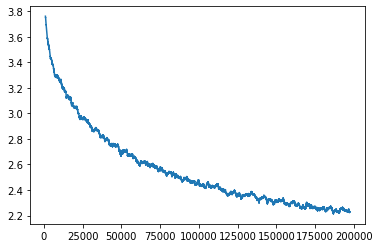

In [221]:
pd.Series(losses).ewm(1000).mean()[1000:].plot();
len(losses)

In [ ]:
loss = None
optimizer.zero_grad(set_to_none=True)
gc.collect()
torch.cuda.empty_cache()

In [248]:
PhrasalConstraint?

Init signature: PhrasalConstraint(token_ids: List[int])
Docstring:     
[`Constraint`] enforcing that an ordered sequence of tokens is included in the output.

Args:
    token_ids (`List[int]`):
        The id of the token that must be generated by the output.
File:           ~/code/research_mention_decoder/.venv/lib/python3.10/site-packages/transformers/generation_beam_constraints.py
Type:           ABCMeta
Subclasses:     


In [274]:
force_words = [s.ent for s in batch]
constraints = [
    PhrasalConstraint(
        dec_tokenizer(w).input_ids
    )
    for w in force_words
]
# force_words_ids = [
#     dec_tokenizer(force_words, add_special_tokens=False).input_ids,
#     # tokenizer(force_flexible, add_prefix_space=True, add_special_tokens=False).input_ids,
# ]
force_word_ids = dec_tokenizer(force_words, add_special_tokens=False).input_ids

In [275]:
force_word_ids

[[1426, 10486, 277],
 [259, 12910, 259, 277, 19418, 24355, 833, 277],
 [6243, 6716, 354],
 [10726, 6776, 18479, 9308, 4893, 274, 2167, 14706, 271],
 [1426, 10486, 259, 277, 2814, 16649],
 [259, 277, 24536],
 [1426, 10486, 1483, 16649, 277]]

In [276]:
constraints

In [277]:
next(iter(embeddings)).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 768])

In [282]:
encoder.eval()
embeddings = encode(batch)
decoder.eval()

out_unc = decoder.generate(
    encoder_outputs=BaseModelOutput(last_hidden_state=embeddings.unsqueeze(1)),
    num_beams=2,
    max_length=256, 
    repetition_penalty=3.0)

out = decoder.generate(
    encoder_outputs=BaseModelOutput(last_hidden_state=embeddings.unsqueeze(1)), 
    # constraints=constraints,
    force_words_ids=[force_word_ids],
    num_beams=2,
    max_length=512, 
    repetition_penalty=3.0)


for s, o, ou in zip(batch, out, out_unc):
    
    print("Original:", s.text, f"[{s.ent}]", sep="\t")
    t = dec_tokenizer.decode(o, skip_special_tokens=True)
    print("Constrained:", t, sep="\t")
    print(s.ent in t)
    t = dec_tokenizer.decode(ou, skip_special_tokens=True)
    print("Unconstrained:", t, sep="\t")
    print(s.ent in t)
    print('-----------')
    

Original:	'Интер РАО' продолжает рассматривать возможность вторичного размещения своих акций за рубежом.	[РАО']
Coonstrained:	'Интер РАО' продолжает рассматривать возможность размещения активов на других международных площадках.
True
Unconstrained:	'РАО 'Интер РАО' продолжает рассматривать возможности по открытию инвестиций в другие страны.
True
-----------
Original:	1,4% — НК 'Роснефть'.	[НК 'Роснефть']
Coonstrained:	НК 'Роснефть', принадлежащая НПО 'Роснефти'.
True
Unconstrained:	Это - 'Роснефть'.
False
-----------
Original:	14,8% — напрямую Росимуществу;	[Росимуществу]
Coonstrained:	НК 'Роснефть' непосредственно вступает в реестр, почти половину чистой прибыли.
False
Unconstrained:	Официально его доля непосредственно принадлежит Росимуществу.
True
-----------
Original:	Крупнейший пакет акций (19,95%) принадлежит Федеральной сетевой компании (ФСК);	[Федеральной сетевой компании (ФСК)]
Coonstrained:	В НК 'Роснефть' принадлежит почти половина всех активов (25%), входящих в реестр.
Fals

In [283]:
for s, emb, fwi in zip(batch, embeddings, force_word_ids):
    emb = emb.unsqueeze(0).unsqueeze(0)
    out = decoder.generate(
        encoder_outputs=BaseModelOutput(last_hidden_state=emb), 
        # constraints=constraints,
        force_words_ids=[[fwi]],
        num_beams=2,
        max_length=512, 
        repetition_penalty=3.0)
    t = dec_tokenizer.decode(out[0], skip_special_tokens=True)
    
    print("Original:", s.text, f"[{s.ent}]", sep="\t")
    print("Constrained:", t, sep="\t")
    print(s.ent in t)
    print('-----------')

Original:	'Интер РАО' продолжает рассматривать возможность вторичного размещения своих акций за рубежом.	[РАО']
Coonstrained:	РАО' продолжает рассматривать новые возможности по продаже активов на международном рынке.
True
-----------
Original:	1,4% — НК 'Роснефть'.	[НК 'Роснефть']
Coonstrained:	НК 'Роснефть', принадлежащая НПО 'Роснефти'.
True
-----------
Original:	14,8% — напрямую Росимуществу;	[Росимуществу]
Coonstrained:	Росимуществу, скорее всего, принадлежит 14,9% акций Ренессанс Капитала.
True
-----------
Original:	Крупнейший пакет акций (19,95%) принадлежит Федеральной сетевой компании (ФСК);	[Федеральной сетевой компании (ФСК)]
Coonstrained:	Федеральной сетевой компании (ФСК) является крупнейшим участником сделки — 19,25%.
True
-----------
Original:	После размещения 'большой допэмиссии', в рамках которой 'Интер РАО' в обмен на свои новые акции получило от государства и госкомпаний неприватизированные при реформе РАО 'ЕЭС России' энергоактивы, у компании нет контролирующего акци

In [ ]:
decoder.save_pretrained(save_model_path)
dec_tokenizer.save_pretrained(save_model_path)

('/gd/MyDrive/models/rut5-base-labse-decoder/tokenizer_config.json',
 '/gd/MyDrive/models/rut5-base-labse-decoder/special_tokens_map.json',
 '/gd/MyDrive/models/rut5-base-labse-decoder/spiece.model',
 '/gd/MyDrive/models/rut5-base-labse-decoder/added_tokens.json',
 '/gd/MyDrive/models/rut5-base-labse-decoder/tokenizer.json')

In [ ]:
decoder.eval();

In [ ]:
embeddings = encode([
    "4 декабря 2000 года",
    "Давно такого не читала, очень хорошо пишешь!",
    "Я тогда не понимала, что происходит, не понимаю и сейчас.",
    "London is the capital of Great Britain.",
])
print(embeddings.shape)
# torch.Size([4, 768])

torch.Size([4, 768])


In [ ]:
for text in decode(embeddings):
    print(text)

После 4 декабря 2000 года
Не так давно, это многое читала!
Я не понимала того, что происходит сейчас тогда, дальше.
Британская столица Англии.
